In [1]:
!pip install pydicom

  Obtaining dependency information for pydicom from https://files.pythonhosted.org/packages/27/a6/98651e752a49f341aa99aa3f6c8ba361728dfc064242884355419df63669/pydicom-3.0.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 4.9 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install opencv-python-headless

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/dc/53/2c50afa0b1e05ecdb4603818e85f7d174e683d874ef63a6abe3ac92220c8/opencv_python_headless-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 2.1 MB/s eta 0:00:0000:0100:01


In [41]:
import os
import numpy as np
import pydicom
import cv2
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
import os, cv2, numpy as np
import zipfile
from tqdm import tqdm

# Updated base paths
base_path = "/Users/saradapriyamns/Desktop/ML MATH/Project"
out_path = os.path.join(base_path, "processed_npz")
image_size = (128, 128)
window_type = "brain_bone_window"


In [43]:
def unzip_and_process_class(classname):
    zip_path = os.path.join(base_path, f"{classname}.zip")
    extract_path = os.path.join(base_path, classname)

    # Unzip if needed
    if not os.path.exists(extract_path):
        print(f"Unzipping {classname}.zip...")
        os.makedirs(extract_path, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    else:
        print(f"Already unzipped: {classname}")

    # 🔍 Auto-find brain_bone_window folder
    full_path = None
    for root, dirs, files in os.walk(extract_path):
        if os.path.basename(root) == window_type:
            full_path = root
            break

    if not full_path or not os.path.exists(full_path):
        print(f"Could not find '{window_type}' in {extract_path}")
        return

    print(f"Processing: {classname}/{window_type}")
    images, labels = [], []
    
    for fname in tqdm(os.listdir(full_path)):
        if fname.endswith(".jpg"):
            try:
                img = cv2.imread(os.path.join(full_path, fname), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(classname)
            except Exception as e:
                print(f"⚠️ Error reading {fname}: {e}")

    os.makedirs(out_path, exist_ok=True)
    np.savez_compressed(os.path.join(out_path, f"{classname}.npz"),
                        images=np.array(images), labels=np.array(labels))
    print(f"Saved {len(images)} images to {classname}.npz")


In [7]:
classes = ["epidural", "normal", "subdural", "subarachnoid", "intraventricular", "intraparenchymal", "multi"]

for cls in classes:
    print(f"\nStarting: {cls}")
    unzip_and_process_class(cls)



🔄 Starting: epidural
✅ Already unzipped: epidural
🧠 Processing: epidural/brain_bone_window


100%|██████████| 1694/1694 [00:00<00:00, 2650.70it/s]


✅ Saved 1694 images to epidural.npz

🔄 Starting: normal
✅ Already unzipped: normal
🧠 Processing: normal/brain_bone_window


100%|██████████| 10700/10700 [00:04<00:00, 2485.95it/s]


✅ Saved 10700 images to normal.npz

🔄 Starting: subdural
✅ Already unzipped: subdural
🧠 Processing: subdural/brain_bone_window


100%|██████████| 32200/32200 [00:13<00:00, 2464.34it/s]


✅ Saved 32200 images to subdural.npz

🔄 Starting: subarachnoid
✅ Already unzipped: subarachnoid
🧠 Processing: subarachnoid/brain_bone_window


100%|██████████| 16423/16423 [00:07<00:00, 2219.76it/s]


✅ Saved 16423 images to subarachnoid.npz

🔄 Starting: intraventricular
✅ Already unzipped: intraventricular
🧠 Processing: intraventricular/brain_bone_window


100%|██████████| 9878/9878 [00:04<00:00, 2380.62it/s]


✅ Saved 9878 images to intraventricular.npz

🔄 Starting: intraparenchymal
✅ Already unzipped: intraparenchymal
🧠 Processing: intraparenchymal/brain_bone_window


100%|██████████| 15664/15664 [00:07<00:00, 2208.91it/s]


✅ Saved 15664 images to intraparenchymal.npz

🔄 Starting: multi
✅ Already unzipped: multi
🧠 Processing: multi/brain_bone_window


100%|██████████| 32074/32074 [00:16<00:00, 1951.60it/s]


✅ Saved 32074 images to multi.npz


In [ ]:
def load_combined_npz(npz_dir):
    X_all, y_all = [], []
    for fname in os.listdir(npz_dir):
        if fname.endswith(".npz"):
            data = np.load(os.path.join(npz_dir, fname))
            X_all.append(data["images"])
            y_all.append(data["labels"])
    return np.concatenate(X_all), np.concatenate(y_all)

# Load dataset
X_images, y_labels = load_combined_npz(out_path)

print(f"Loaded {len(X_images)} images from npz files")


✅ Loaded 118633 images from npz files


In [9]:
from scipy.stats import skew, kurtosis

def extract_advanced_features(img):
    flat = img.flatten()
    edges = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=3)
    edge_count = np.sum(np.abs(edges) > 30)

    return [
        np.mean(flat),
        np.std(flat),
        np.min(flat),
        np.max(flat),
        np.median(flat),
        skew(flat),
        kurtosis(flat),
        edge_count
    ]

# ⚡ Vectorized-ish feature extraction
features = []
for img in tqdm(X_images, desc="🧠 Extracting features"):
    features.append(extract_advanced_features(img))

X_features = np.array(features)


🧠 Extracting features: 100%|██████████| 118633/118633 [01:03<00:00, 1875.18it/s]


In [10]:
print("NaNs in features:", np.isnan(X_features).sum())
print("Infs in features:", np.isinf(X_features).sum())


NaNs in features: 46
Infs in features: 0


In [11]:
X_features_clean = np.nan_to_num(X_features, nan=0.0, posinf=0.0, neginf=0.0)
print("X shape:", X_features_clean.shape)
print("Example feature vector:", X_features_clean[0])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

print("y_encoded shape:", y_encoded.shape)
print("Unique label values:", np.unique(y_encoded))

print("Label encoding mapping:")
for idx, class_name in enumerate(le.classes_):
    print(f"{idx}: {class_name}")



X shape: (118633, 8)
Example feature vector: [3.08905640e+01 4.64387820e+01 0.00000000e+00 2.54000000e+02
 0.00000000e+00 1.59867800e+00 2.72335367e+00 1.79700000e+03]
y_encoded shape: (118633,)
Unique label values: [0 1 2 3 4 5 6]
Label encoding mapping:
0: epidural
1: intraparenchymal
2: intraventricular
3: multi
4: normal
5: subarachnoid
6: subdural


In [12]:
pip install -U scikit-learn==1.3.2 imbalanced-learn==0.11.0


Note: you may need to restart the kernel to use updated packages.


In [31]:
from sklearn.model_selection import train_test_split

# Reserve 15% for final testing
X_rest, X_holdout, y_rest, y_holdout = train_test_split(
    X_features_clean, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42
)


In [39]:
# Use same random state for reproducibility
from sklearn.model_selection import train_test_split

# First split off the holdout test set
X_feat_main, X_feat_holdout, y_main, y_holdout, imgs_main, imgs_holdout = train_test_split(
    X_features_clean, y_encoded, X_images, test_size=0.15, stratify=y_encoded, random_state=42
)

# Apply SMOTE only to the main training portion
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_feat_main, y_main)

# Then split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Validation
y_val_rf = rf.predict(X_val)
print("📊 Random Forest - Validation:")
print(classification_report(y_val, y_val_rf, target_names=le.classes_))

# Final test
y_test_rf = rf.predict(X_feat_holdout)
print("🚀 Random Forest - Final Test:")
print(classification_report(y_holdout, y_test_rf, target_names=le.classes_))


📊 Random Forest - Validation:
                  precision    recall  f1-score   support

        epidural       0.74      0.88      0.80      5474
intraparenchymal       0.50      0.44      0.47      5474
intraventricular       0.56      0.68      0.61      5474
           multi       0.39      0.39      0.39      5474
          normal       0.65      0.64      0.64      5474
    subarachnoid       0.51      0.44      0.47      5474
        subdural       0.38      0.34      0.36      5474

        accuracy                           0.54     38318
       macro avg       0.53      0.54      0.54     38318
    weighted avg       0.53      0.54      0.54     38318

🚀 Random Forest - Final Test:
                  precision    recall  f1-score   support

        epidural       0.07      0.22      0.10       254
intraparenchymal       0.24      0.22      0.23      2350
intraventricular       0.21      0.31      0.25      1482
           multi       0.41      0.39      0.40      4811
        

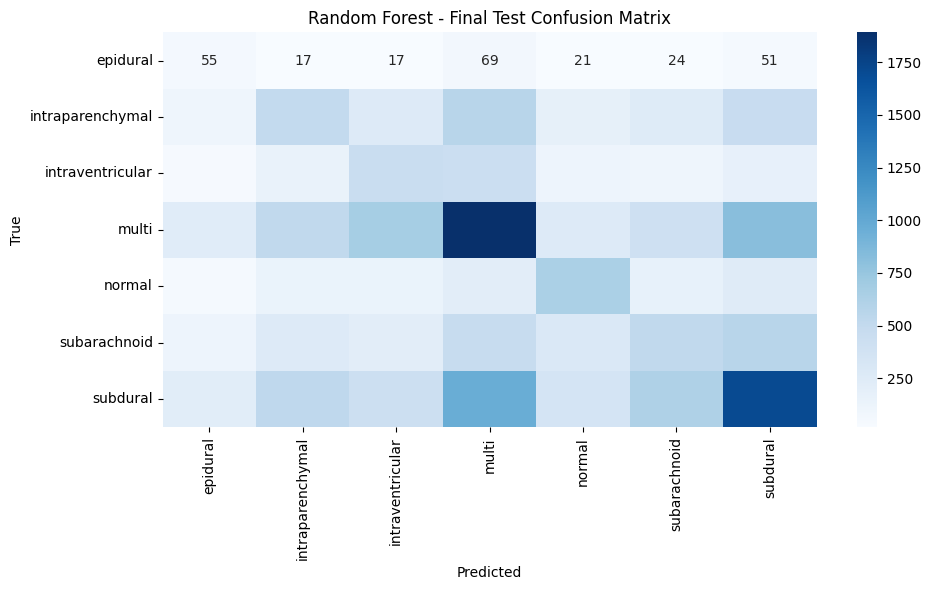

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_holdout, y_test_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Final Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Validation
y_val_xgb = xgb.predict(X_val)
print("📊 XGBoost - Validation:")
print(classification_report(y_val, y_val_xgb, target_names=le.classes_))

# Final test
y_test_xgb = xgb.predict(X_feat_holdout)
print("🚀 XGBoost - Final Test:")
print(classification_report(y_holdout, y_test_xgb, target_names=le.classes_))


/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:53:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 XGBoost - Validation:
                  precision    recall  f1-score   support

        epidural       0.57      0.69      0.63      5474
intraparenchymal       0.36      0.14      0.20      5474
intraventricular       0.41      0.42      0.42      5474
           multi       0.31      0.54      0.40      5474
          normal       0.57      0.46      0.51      5474
    subarachnoid       0.39      0.19      0.26      5474
        subdural       0.33      0.44      0.38      5474

        accuracy                           0.41     38318
       macro avg       0.42      0.41      0.40     38318
    weighted avg       0.42      0.41      0.40     38318

🚀 XGBoost - Final Test:
                  precision    recall  f1-score   support

        epidural       0.05      0.07      0.06       254
intraparenchymal       0.24      0.08      0.12      2350
intraventricular       0.20      0.20      0.20      1482
           multi       0.37      0.53      0.43      4811
          normal    

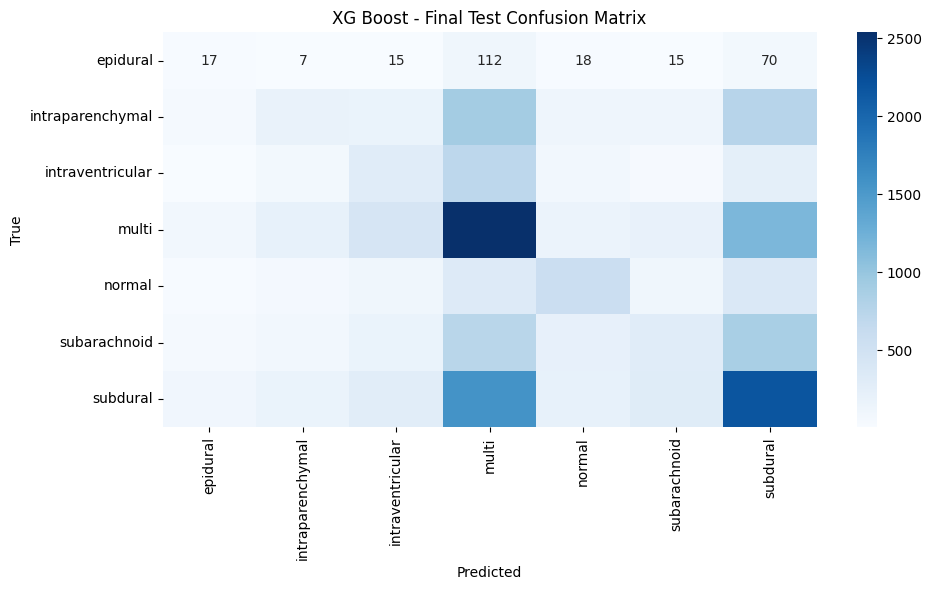

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_holdout, y_test_xgb), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XG Boost - Final Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [49]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', n_jobs=-1, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, random_state=42)

voting_clf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='hard')
voting_clf.fit(X_train, y_train)


/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feat...
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None, ...))])

In [50]:
from sklearn.metrics import classification_report

y_val_pred = voting_clf.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


Validation Report:
                  precision    recall  f1-score   support

        epidural       0.58      0.92      0.71      5474
intraparenchymal       0.43      0.41      0.42      5474
intraventricular       0.48      0.60      0.53      5474
           multi       0.37      0.45      0.41      5474
          normal       0.61      0.52      0.56      5474
    subarachnoid       0.46      0.25      0.32      5474
        subdural       0.43      0.24      0.31      5474

        accuracy                           0.49     38318
       macro avg       0.48      0.49      0.47     38318
    weighted avg       0.48      0.49      0.47     38318



In [51]:
y_test_vote = voting_clf.predict(X_feat_holdout)
print("🚀 Voting Classifier - Final Test:")
print(classification_report(y_holdout, y_test_vote, target_names=le.classes_))


🚀 Voting Classifier - Final Test:
                  precision    recall  f1-score   support

        epidural       0.06      0.23      0.09       254
intraparenchymal       0.23      0.24      0.23      2350
intraventricular       0.19      0.34      0.24      1482
           multi       0.38      0.44      0.41      4811
          normal       0.37      0.39      0.38      1605
    subarachnoid       0.26      0.16      0.20      2463
        subdural       0.44      0.26      0.32      4830

        accuracy                           0.31     17795
       macro avg       0.28      0.29      0.27     17795
    weighted avg       0.34      0.31      0.31     17795



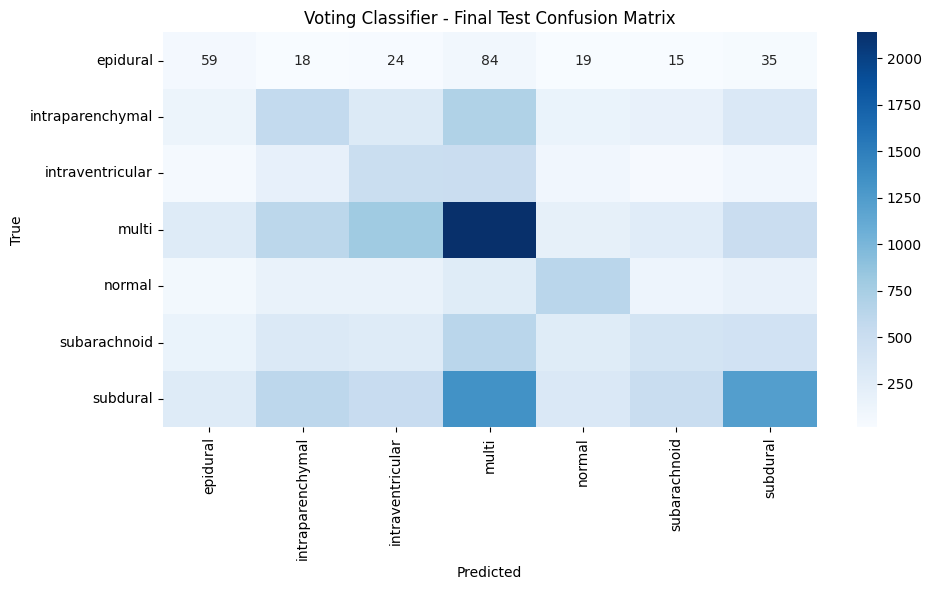

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_holdout, y_test_vote), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Voting Classifier - Final Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [53]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np


In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', n_jobs=-1, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(rf, X_balanced, y_balanced, cv=skf, scoring='accuracy')
print("🌲 Random Forest CV Scores:", rf_scores)
print("📈 RF Mean Accuracy:", np.mean(rf_scores))


🌲 Random Forest CV Scores: [0.54864555 0.54580093 0.54593142 0.54473094 0.54279973]
📈 RF Mean Accuracy: 0.5455817109452477


In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, random_state=42)

xgb_scores = cross_val_score(xgb, X_balanced, y_balanced, cv=skf, scoring='accuracy')
print("⚡ XGBoost CV Scores:", xgb_scores)
print("📈 XGB Mean Accuracy:", np.mean(xgb_scores))


/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:58:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:58:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

⚡ XGBoost CV Scores: [0.41962002 0.41776711 0.41562712 0.41557493 0.41664492]
📈 XGB Mean Accuracy: 0.417046818727491


In [56]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb)
], voting='hard')

ensemble_scores = cross_val_score(voting_clf, X_balanced, y_balanced, cv=skf, scoring='accuracy')
print("🧠 Voting Ensemble CV Scores:", ensemble_scores)
print("📈 Ensemble Mean Accuracy:", np.mean(ensemble_scores))


/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

🧠 Voting Ensemble CV Scores: [0.49123128 0.48903909 0.48869983 0.48804739 0.48948275]
📈 Ensemble Mean Accuracy: 0.48930006785322827


/var/folders/cb/bry7c9xs6z53s8_q3km913c40000gn/T/ipykernel_81556/1730508662.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


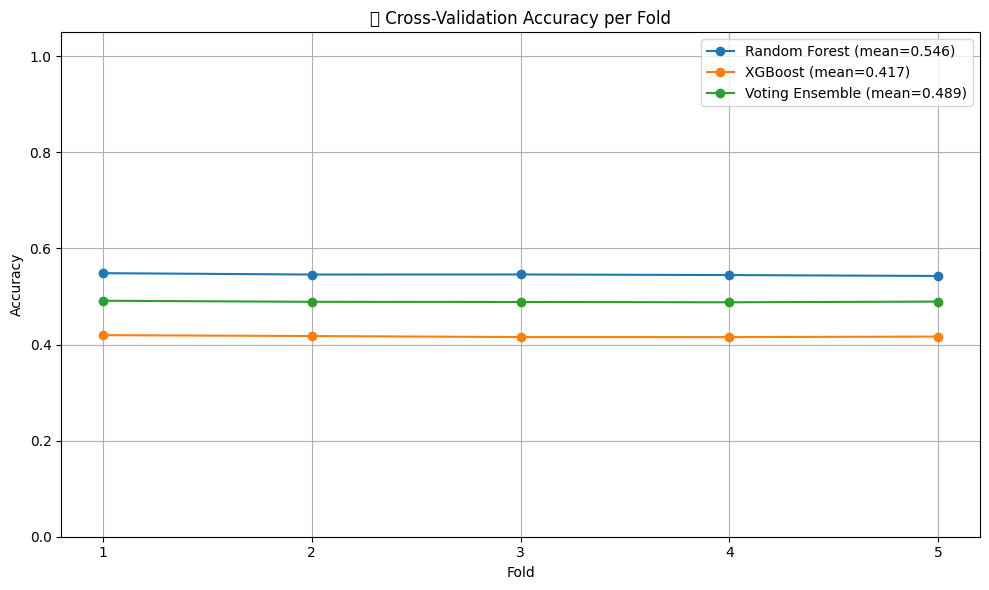

In [57]:
import matplotlib.pyplot as plt

# 🧪 Collect results into a dictionary
cv_results = {
    "Random Forest": rf_scores,
    "XGBoost": xgb_scores,
    "Voting Ensemble": ensemble_scores
}

# 📊 Plot
plt.figure(figsize=(10, 6))
for label, scores in cv_results.items():
    plt.plot(range(1, len(scores)+1), scores, marker='o', label=f"{label} (mean={scores.mean():.3f})")

plt.title("📈 Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.xticks(range(1, 6))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


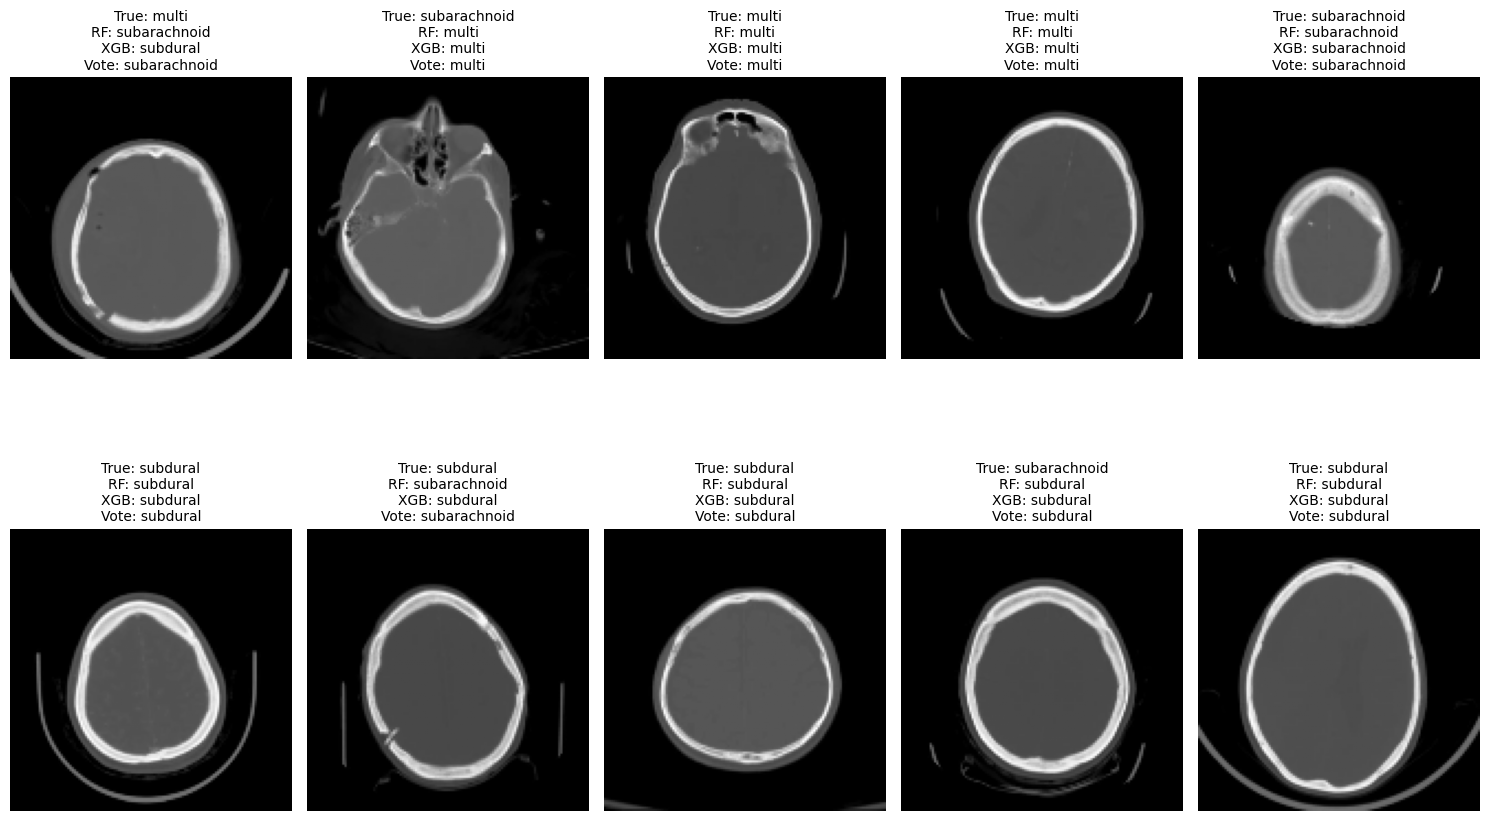

In [60]:
import matplotlib.pyplot as plt
import random

# 👇 Fit individual models separately
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


# Then train the ensemble
voting_clf.fit(X_train, y_train) 

# 🔁 Pick random samples to visualize
num_samples = 10
indices = random.sample(range(len(X_feat_holdout)), num_samples)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    feature_vector = X_feat_holdout[idx].reshape(1, -1)
    
    # 🧠 Predict using chosen model
    pred_rf = rf.predict(feature_vector)[0]
    pred_xgb = xgb.predict(feature_vector)[0]
    pred_vote = voting_clf.predict(feature_vector)[0]
    
    true_label = y_holdout[idx]
    
    # 🎯 Decode labels
    true_label_name = le.inverse_transform([true_label])[0]
    rf_label_name = le.inverse_transform([pred_rf])[0]
    xgb_label_name = le.inverse_transform([pred_xgb])[0]
    vote_label_name = le.inverse_transform([pred_vote])[0]
    
    # 🖼️ Show image
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs_holdout[idx], cmap='gray')
    plt.title(
        f"True: {true_label_name}\nRF: {rf_label_name}\nXGB: {xgb_label_name}\nVote: {vote_label_name}",
        fontsize=10
    )
    plt.axis('off')

plt.tight_layout()
plt.show()


/Users/saradapriyamns/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:05:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


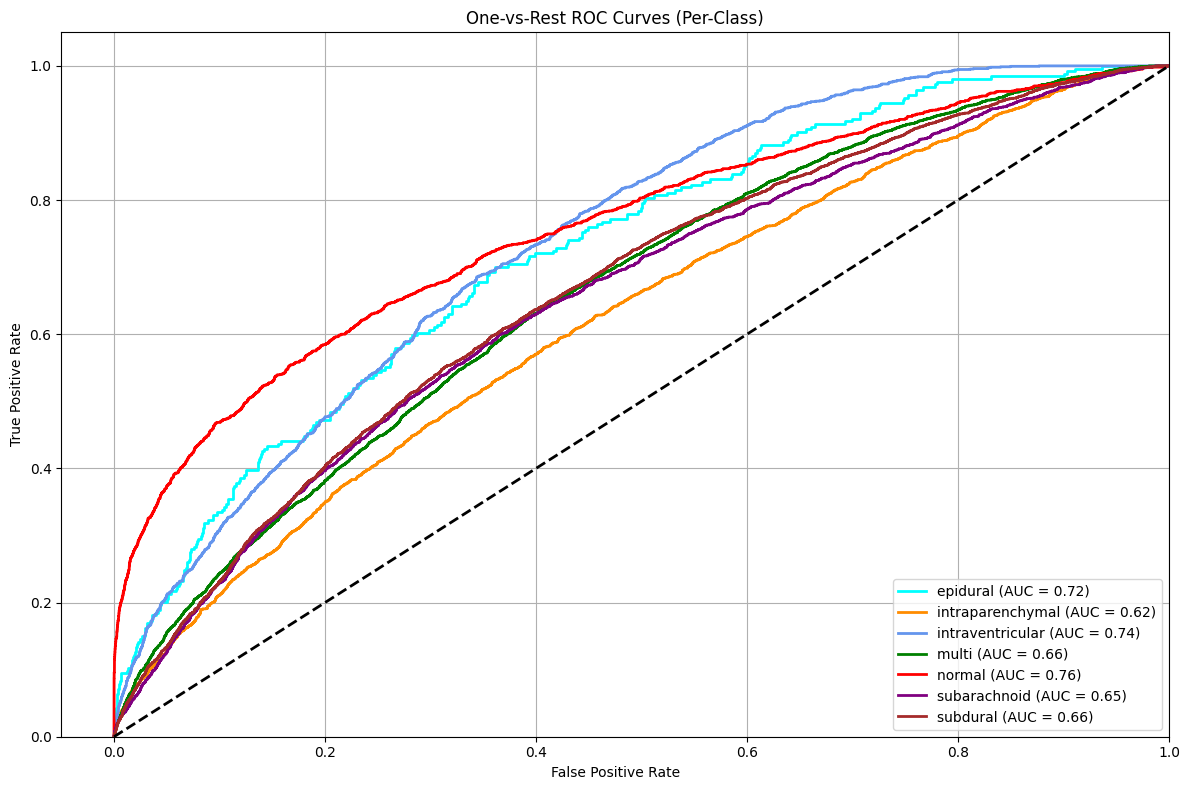

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# 🧪 Use your validation or test set (e.g., holdout set)
y_true = y_holdout
X_input = X_feat_holdout  # Features of holdout set

# 🧠 Get probabilistic predictions (required for ROC)
# NOTE: VotingClassifier must be soft voting for this
voting_soft = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')
voting_soft.fit(X_train, y_train)
y_score = voting_soft.predict_proba(X_input)

# 🎯 Binarize the output
y_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))
n_classes = y_bin.shape[1]

# 🎨 Plotting
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves (Per-Class)')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


# SEGMENTATION CODE BELOW



In [2]:
# checking if mask and epidural images are matching
import os

image_dir = "/Users/saradapriyamns/Desktop/ML MATH/Project/epidural/epidural/brain_bone_window/"

mask_dir = "/Users/saradapriyamns/Desktop/ML MATH/Project/bi-masks"

# List a few image files
print("📂 Sample image files:")
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
print(image_files[:5])

# List a few mask files
print("\n📂 Sample mask files:")
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])
print(mask_files[:5])

# 🔁 Check intersection of matching filenames
matched = [f for f in image_files if f in mask_files]
print(f"\n✅ Matched image-mask pairs: {len(matched)}")
print("Sample matches:", matched[:5])


📂 Sample image files:
['ID_000edbf38.jpg', 'ID_00178eb80.jpg', 'ID_001bb2c00.jpg', 'ID_0026de01c.jpg', 'ID_004966e2d.jpg']

📂 Sample mask files:
['ID_0002081b6.jpg', 'ID_001b1b944.jpg', 'ID_0048e60a4.jpg', 'ID_004c4b319.jpg', 'ID_0057d2736.jpg']

✅ Matched image-mask pairs: 460
Sample matches: ['ID_004c4b319.jpg', 'ID_0237b835f.jpg', 'ID_02e2d273d.jpg', 'ID_02f37ce84.jpg', 'ID_03c6a01ca.jpg']


In [50]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [51]:
class CTMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = file_list

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise ValueError(f"Failed to read image or mask for {img_name}")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = mask.unsqueeze(0) / 255.0  # Normalize
        return image, mask


In [52]:
# Point to directories
image_dir = "/Users/saradapriyamns/Desktop/ML MATH/Project/epidural/epidural/brain_bone_window"
mask_dir = "/Users/saradapriyamns/Desktop/ML MATH/Project/bi-masks"

# Get all .jpg that have a corresponding mask
all_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(mask_dir, f))]
print("Total matched files:", len(all_files))

# Select a small subset
selected_files = all_files[:250]  # 200 train, 50 test
train_files = selected_files[:200]
val_files = selected_files[200:]

transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])



Total matched files: 460


In [53]:
train_dataset = CTMaskDataset(image_dir, mask_dir, train_files, transform=transform)
val_dataset = CTMaskDataset(image_dir, mask_dir, val_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [54]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [55]:
def dice_coeff(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.item()

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


In [56]:
for epoch in range(1, 6):
    model.train()
    train_loss, train_dice = 0, 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coeff(preds, masks)

    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            val_loss += loss_fn(preds, masks).item()
            val_dice += dice_coeff(preds, masks)

    print(f"📅 Epoch {epoch}: "
          f"Train Loss: {train_loss:.4f}, Dice: {train_dice/len(train_loader):.4f} | "
          f"Val Loss: {val_loss:.4f}, Dice: {val_dice/len(val_loader):.4f}")


📅 Epoch 1: Train Loss: 12.9581, Dice: 0.0000 | Val Loss: 2.3874, Dice: 0.0000
📅 Epoch 2: Train Loss: 3.8093, Dice: 0.0000 | Val Loss: 0.3291, Dice: 0.0000
📅 Epoch 3: Train Loss: 1.1862, Dice: 0.0000 | Val Loss: 0.2796, Dice: 0.0000
📅 Epoch 4: Train Loss: 1.1598, Dice: 0.0000 | Val Loss: 0.2769, Dice: 0.0000
📅 Epoch 5: Train Loss: 1.1432, Dice: 0.0000 | Val Loss: 0.2759, Dice: 0.0000


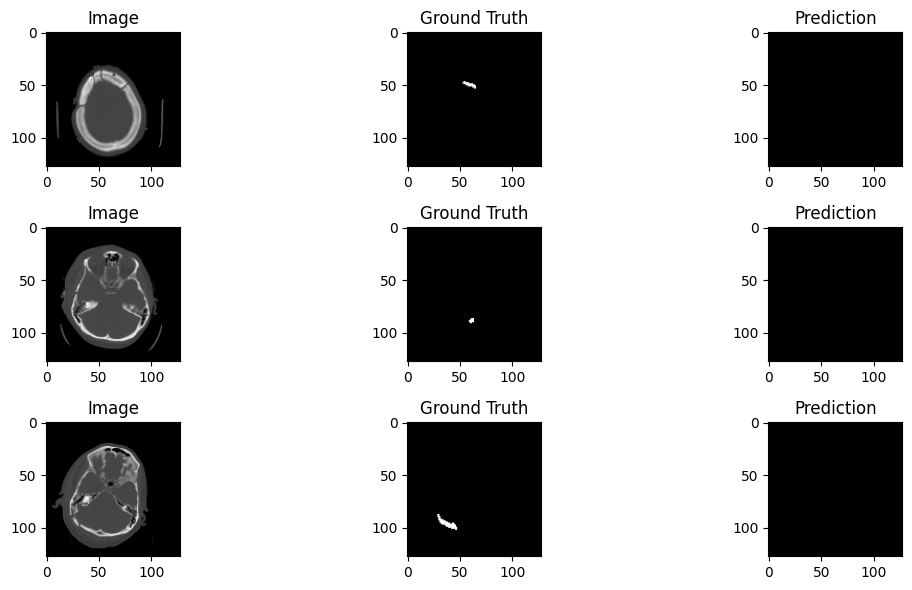

In [57]:
model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)
preds = model(imgs)

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i*3+1)
    plt.imshow(imgs[i][0].cpu(), cmap='gray')
    plt.title("Image")

    plt.subplot(3, 3, i*3+2)
    plt.imshow(masks[i][0].cpu(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(3, 3, i*3+3)
    plt.imshow(preds[i][0].detach().cpu() > 0.5, cmap='gray')
    plt.title("Prediction")

plt.tight_layout()
plt.show()
